In [ ]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage


c:\Users\jw160\project\RAG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [31]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.messages import HumanMessage, AIMessage

In [32]:
# 샘플 문서 데이터
documents = [
    "인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.",
    "머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.",
    "딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.",
    "자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.",
    "컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다."
]

# Document 객체로 변환
docs = [Document(page_content=text) for text in documents]

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
splits = text_splitter.split_documents(docs)

In [50]:
embeddings = HuggingFaceEndpointEmbeddings(client="http://127.0.0.1:8080/")
vectorstore = InMemoryVectorStore.from_documents(splits, embeddings)

In [2]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [54]:
model = init_chat_model(
    "smollm",
    model_provider="ollama",
    base_url="http://localhost:11434",
    temperature=0,
    max_tokens=50
)


In [59]:
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model.invoke(
                [
                    SystemMessage(
                        content="You are a friendly helper. Respond to users' questions in a friendly manner."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [ ]:
graph = StateGraph(MessagesState)
graph.add_node(llm_call)
graph.add_edge(START, "llm_call")
graph.add_edge("llm_call", END)
graph = graph.compile()

In [61]:
graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})

{'messages': [{'role': 'user', 'content': 'hi!'},
  AIMessage(content='Hello there! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'smollm', 'created_at': '2025-12-03T14:49:28.391418373Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3458367825, 'load_duration': 62214100, 'prompt_eval_count': 32, 'prompt_eval_duration': 1330341099, 'eval_count': 11, 'eval_duration': 2050348466, 'logprobs': None, 'model_name': 'smollm', 'model_provider': 'ollama'}, id='lc_run--60e9bfaf-1d1e-4510-9a96-62745748b6ca-0', usage_metadata={'input_tokens': 32, 'output_tokens': 11, 'total_tokens': 43})],
 'llm_calls': 1}

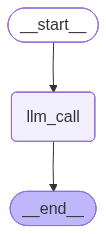

In [62]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))